In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import glob
%matplotlib inline

In [16]:
# Create and test the video sequence for the Car4 dataset

vid_seq = []

# Iterate through all the images with .jpg extension
for file in glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Car4\\img\\*.jpg'):
    
    #Read the images sequentially and append them in the vid_seq list
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    vid_seq.append(img)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('Car.avi',fourcc,5.0,size)

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

In [17]:
# Create and test the video sequence for the Bolt dataset

vid_seq = []

# Iterate through all the images with .jpg extension
for file in glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\*.jpg'):
    
    # Read the images sequentially and append them in the vid_seq list
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    vid_seq.append(img)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('Bolt.avi',fourcc,5.0,size)

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

In [17]:
# Create and test the video sequence for the BabyDragon dataset

vid_seq = []

# Iterate through all the images with .jpg extension
for file in glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\DragonBaby\\img\\*.jpg'):
    
    # Read the images sequentially and append them in the vid_seq list
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    vid_seq.append(img)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('DragonBaby.avi',fourcc,20.0,size)

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

## Implementation of the Lucas Kanade metod for Affine Warp

Warp the image $I$ to obtain $I(W[x,y];P)$

Compute the error image $T(x)-I(W[x,y];P)$

Warp the Gradient ${\nabla{I}}$ with $(W[x,y];P)$

Evaluate $\frac{\partial W}{\partial P}$ at $([x,y];P)$

Compute Steepest descent images ${\nabla{I}}\frac{\partial W}{\partial P}$

Compute the Hessian Matrix $\sum{({\nabla{I}}\frac{\partial W}{\partial P})}^{T}{{\nabla{I}}\frac{\partial W}{\partial P}}$

Compute $\sum{({\nabla{I}}\frac{\partial W}{\partial P})}{(T(x)-I(W[x,y];P))}$

Compute ${\Delta P}$

$P{\leftarrow}P+{\Delta P}$

Keep Iterating till the magnitude of ${\Delta P}$ is negligible

And also ${\Delta P} = {({A}^{T}{A}})^{-1}{A^{T}}{b}$

Here ${{A}^{T}{A}}$ is the Hessian Matrix that has been computed above and $A$ is the steepest descent image and $b$ is basicallty the error image that has been computed in step 2

Affine Transform is given as ${\begin{bmatrix} 1+{p_1} & {p_3} & {p_5}\\ {p_2} & {1+{p_4}} & {p_{6}}\\0&0&1\\\end{bmatrix}}$

In [71]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
import glob
%matplotlib inline

# Get a grayscale image to input in the Lucas Kanade 
def get_grayscale_image(image):
    
    """
    Inputs:
    path_to_frame: The path to the frame that needs to be converted to a grayscale image: dtype=string
    
    """
    grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    grayscale = cv2.GaussianBlur(grayscale, (3, 3),0)  
    return grayscale

# Reference: CMU Graduate computer Vision Course
def crop_warped(image,rect):
    
    """
    Inputs:
    image: The warped image after performing an affine transformation
    rect: The upleft and the truth bounding box
    
    """
    #warped = image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    warped = image[rect[1]:rect[3], rect[0]:rect[2]]
    return warped
    
def LucasKanadeAffine(image,template,rect,p,threshold, iterations):
    
    """
    Inputs:
    
    image: The input gray scale image
    template: The template image
    rect: The top left coordinates and the bottom right coordinates of the rectangle format--> [x1,y1,x2,y2]
    threshold: The threshold that has been set to terminate the iterations as soon as delta p value approaches the threshold value
    parameters: The initial parameters of the affine warp
    iterations: Number of times the algorithm needs to run
    
    Returns:
    p: Paramters of the affine warp matrix
    Upper left bounding bax coordinates
    Downright bounding box coordinates
    """
    # Crop the region of interest from the template frame
    template = crop_warped(template,rect)
    
    # Parameters of the affine matrix
    #p = np.array([parameters]).reshape(-1,1)
    
    # Threshold for convergence
    thresh = threshold
    
    # Initial Affine Matrix
    #affine_matrix = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0]])
    
    # affine matrix
    affine_matrix = np.array([[1 + p[0][0], p[2][0], p[4][0]], [p[1][0], 1 + p[3][0], p[5][0]]], dtype = np.float32)
    
    #I = affine_matrix
    # Compute the image gradient in the x direction
    sobelx = cv2.Sobel(image, cv2.CV_64F, dx = 1, dy = 0, ksize = 7)
    
    # Compute the image gradient in the y direction
    sobely = cv2.Sobel(image, cv2.CV_64F, dx = 0, dy = 1, ksize = 7)
    
    for iteration in range(iterations):
        
        # Warp the input image
        warped_image = cv2.warpAffine(image, affine_matrix, (0, 0), flags=cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)
        
        # Compute the error image
        error_image = template - crop_warped(warped_image, rect)
        
        # Compute the warped gradient in the x direction
        sobel_x_warped = cv2.warpAffine(sobelx, affine_matrix, (0,0), flags=cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)
        
        # Crop the Region of interest in our image gradient
        sobel_x_cropped = crop_warped(sobel_x_warped, rect)
        
        # Compute the warped gradient in the y direction
        sobel_y_warped = cv2.warpAffine(sobely, affine_matrix, (0,0), flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP)
        
        # Crop the Region of interest in our image gradient
        sobel_y_cropped = crop_warped(sobel_y_warped, rect)
        
        # Flatten out the warped gradients
        sobel_x_cropped = sobel_x_cropped.reshape(-1,1)
        sobel_y_cropped = sobel_y_cropped.reshape(-1,1)
        
        # Warp the image gradient with the warping function to produce an mx2 matrix
        # Horizontally stack the derivatives
        gradient_image_warped = np.hstack((sobel_x_cropped,sobel_y_cropped))
        
        # Evaluate the Jacobian and the steepest descent 
        count = 0
        steepest_descent = []
        for y in range(rect[1],rect[3]):
            for x in range(rect[0],rect[2]):
                
                Jacobian = [x*sobel_x_cropped[count][0], x*sobel_y_cropped[count][0], y*sobel_x_cropped[count][0], y*sobel_y_cropped[count][0], sobel_x_cropped[count][0], sobel_y_cropped[count][0]]
                steepest_descent.append(Jacobian)
                count = count + 1
        steepest_descent = np.array(steepest_descent)
        
        # Calculate the Hessian and inverse hessian from the steepest descent
        sd_params_update = np.dot(steepest_descent.T,error_image.reshape(-1,1))
        hessian = np.dot(steepest_descent.T,steepest_descent)
        hessian_inverse = np.linalg.pinv(hessian)
        
        # Update delta p using solution for least squares
        delta_p = np.dot(hessian_inverse, sd_params_update)
        
        # Update the parameters p
        p = np.reshape(p, (6, 1))
        p = p + delta_p
        #print(f'After Iteration: {iterations} Value of p: {p}')
        
        # Update the affine matrix with the newly generated parameters
        #affine_matrix = p.reshape(2,3) + I
        
        # Convergence test
        if np.linalg.norm(delta_p) <= thresh:
            break
            
    # Updated affine matrix
    affine_matrix = np.array([[(1 + p[0][0]), (p[2][0]), (p[4][0])], [(p[1][0]), (1 + p[3][0]), (p[5][0])]], dtype = np.float32)
    top_left_coordinates = np.array([[rect[0]],[rect[1]],[1]])
    bottom_right_coordinates = np.array([[rect[2]], [rect[3]], [1]])
    updated_top_left_coordinates = np.dot(affine_matrix, top_left_coordinates)
    updated_bottom_right_coordinates = np.dot(affine_matrix, bottom_right_coordinates)
    
    print(f'top_left: {updated_top_left_coordinates} \tbottom_right:{updated_bottom_right_coordinates}')
    return p, updated_top_left_coordinates, updated_bottom_right_coordinates


In [72]:
rect_car = np.array([70,51,107+70,87+51])
rect_bolt = np.array([269,75,303,139])
rect_baby = np.array([160,83,56+160,65+83])

# Create and test the video sequence for the Bolt dataset

files  = glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\*.jpg')

# grayscale template image
template = cv2.imread(files[0])
grayscale_template = get_grayscale_image(template)

# List to append the frame sequences
vid_seq = []

p = np.array([[0, 0, 0, 0, 0, 0]]).T

# Iterate through all the images with .jpg extension
for file in files:
    
    image = cv2.imread(file)
    image_copy = image.copy()
    
    # Input the gray scale image
    grayscale_image = get_grayscale_image(image_copy)
    
    # Run the Lucas Kanade Algorithm
    p, top_left_coordinates, bottom_right_coordinates = LucasKanadeAffine(grayscale_image,grayscale_template,rect_bolt, p,threshold = 0.001, iterations = 35)
    
    # Create a bounding box
    image = cv2.rectangle(image,(int(top_left_coordinates[0][0]),int(top_left_coordinates[1][0])), (int(bottom_right_coordinates[0][0]), int(bottom_right_coordinates[1][0])), (0, 0, 255), 1)
    
    vid_seq.append(image)

# The fourcc code
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Video writer object
out = cv2.VideoWriter('Bolt.avi',fourcc,20.0, (480, 270))

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

top_left: [[269.]
 [ 75.]] 	bottom_right:[[303.]
 [139.]]
top_left: [[268.91669621]
 [ 74.92242302]] 	bottom_right:[[303.09304054]
 [139.19495073]]
top_left: [[268.80534913]
 [ 74.85522616]] 	bottom_right:[[303.20878332]
 [139.37317646]]
top_left: [[268.6167293 ]
 [ 74.74172207]] 	bottom_right:[[303.40128154]
 [139.5408401 ]]
top_left: [[268.42490114]
 [ 74.61887602]] 	bottom_right:[[303.59428726]
 [139.69884143]]
top_left: [[268.4074647 ]
 [ 74.53653202]] 	bottom_right:[[303.68837632]
 [139.83435221]]
top_left: [[268.37194537]
 [ 74.45513551]] 	bottom_right:[[303.75899284]
 [139.92218015]]
top_left: [[268.27887746]
 [ 74.37382803]] 	bottom_right:[[303.99035402]
 [140.0723259 ]]
top_left: [[268.33172193]
 [ 74.32008871]] 	bottom_right:[[304.03726247]
 [140.16884401]]
top_left: [[268.41536615]
 [ 74.26060241]] 	bottom_right:[[304.07436249]
 [140.26725942]]
top_left: [[268.3899524 ]
 [ 74.20403398]] 	bottom_right:[[304.2607337 ]
 [140.40686683]]
top_left: [[268.26361437]
 [ 74.19179228]]

top_left: [[260.55831573]
 [ 69.75378582]] 	bottom_right:[[317.89415238]
 [148.99828878]]
top_left: [[260.44786976]
 [ 69.71026906]] 	bottom_right:[[318.29332349]
 [149.1477903 ]]
top_left: [[260.35555895]
 [ 69.68144282]] 	bottom_right:[[318.62630375]
 [149.257796  ]]
top_left: [[260.28509284]
 [ 69.68316384]] 	bottom_right:[[318.8098743 ]
 [149.28813583]]
top_left: [[260.17477451]
 [ 69.67900166]] 	bottom_right:[[319.06187283]
 [149.35677841]]
top_left: [[260.07942273]
 [ 69.64114523]] 	bottom_right:[[319.30031253]
 [149.43565806]]
top_left: [[259.98605297]
 [ 69.58375975]] 	bottom_right:[[319.48552916]
 [149.54677152]]
top_left: [[259.92961677]
 [ 69.53510927]] 	bottom_right:[[319.60209235]
 [149.6174515 ]]
top_left: [[259.88016271]
 [ 69.47478788]] 	bottom_right:[[319.7045927 ]
 [149.71070557]]
top_left: [[259.81249636]
 [ 69.39719129]] 	bottom_right:[[319.81644791]
 [149.79159673]]
top_left: [[259.72220471]
 [ 69.32057229]] 	bottom_right:[[319.95569327]
 [149.88730499]]
top_left: 

top_left: [[246.75863628]
 [ 64.82370716]] 	bottom_right:[[322.93461852]
 [152.67704147]]
top_left: [[246.11023861]
 [ 64.67808609]] 	bottom_right:[[322.88784081]
 [152.64638473]]
top_left: [[245.5454759 ]
 [ 64.53937823]] 	bottom_right:[[322.78838629]
 [152.61506218]]
top_left: [[244.79107389]
 [ 64.35012043]] 	bottom_right:[[322.89280662]
 [152.62004292]]
top_left: [[244.31510992]
 [ 64.25910172]] 	bottom_right:[[322.99335738]
 [152.6035209 ]]
top_left: [[243.58214512]
 [ 64.08777729]] 	bottom_right:[[323.25312939]
 [152.64985296]]
top_left: [[243.02566179]
 [ 63.95289728]] 	bottom_right:[[323.32575163]
 [152.66083542]]
top_left: [[242.43435796]
 [ 63.79603808]] 	bottom_right:[[323.28023131]
 [152.65992869]]
top_left: [[241.96082683]
 [ 63.73407479]] 	bottom_right:[[323.34889336]
 [152.64276074]]
top_left: [[241.776343  ]
 [ 63.69232245]] 	bottom_right:[[323.3615929 ]
 [152.65434907]]
top_left: [[241.59317786]
 [ 63.62686305]] 	bottom_right:[[323.30005461]
 [152.68330432]]
top_left: 

top_left: [[232.02210083]
 [ 55.32854564]] 	bottom_right:[[326.65649261]
 [155.59530531]]
top_left: [[232.17900951]
 [ 55.3103871 ]] 	bottom_right:[[326.35543735]
 [155.55471268]]
top_left: [[232.37646537]
 [ 55.25633918]] 	bottom_right:[[325.92162424]
 [155.54405303]]
top_left: [[232.34382154]
 [ 55.14740314]] 	bottom_right:[[326.04249765]
 [155.5636857 ]]
top_left: [[232.28655455]
 [ 54.91299497]] 	bottom_right:[[326.09202239]
 [155.60092564]]
top_left: [[232.3661337 ]
 [ 54.56705837]] 	bottom_right:[[326.52964354]
 [155.71159436]]
top_left: [[232.50422596]
 [ 54.16336668]] 	bottom_right:[[326.40468621]
 [155.86848509]]
top_left: [[232.56978587]
 [ 53.85616282]] 	bottom_right:[[326.174202  ]
 [156.08207116]]
top_left: [[232.64833281]
 [ 53.58632697]] 	bottom_right:[[326.15678237]
 [156.30941348]]
top_left: [[232.70452558]
 [ 53.351136  ]] 	bottom_right:[[326.17914091]
 [156.50968274]]
top_left: [[232.56498158]
 [ 53.12567683]] 	bottom_right:[[326.3941077 ]
 [156.70530938]]
top_left: 

64

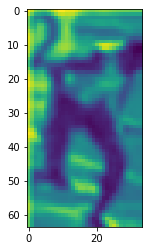

In [79]:
frame1 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\0001.jpg',0)
frame2 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Car4\\img\\0001.jpg',0)
frame3 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\DragonBaby\\img\\0001.jpg',0)

rect_car = [70,51,107+70,87+51]
rect_bolt = np.array([269,75,34+269,64+75])
rect_baby = np.array([160,83,56+160,65+83])

frame1_copy = frame1.copy()
frame1_copy = cv2.rectangle(frame1_copy,(rect_bolt[0],rect_bolt[1]),(rect_bolt[2],rect_bolt[3]),color = (255,0,0),thickness = 1)
template = frame1_copy[rect_bolt[1]:rect_bolt[3],rect_bolt[0]:rect_bolt[2]]
template = cv2.GaussianBlur(template, (3, 3),0)
cv2.imshow('frame 2', frame1_copy)
plt.imshow(template)
frame1.shape
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
template.shape[0]

In [21]:
frame1 = cv2.imread('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\0001.jpg',0)
frame1.shape

(270, 480)

In [119]:
# Get a grayscale image to input in the Lucas Kanade 
def get_grayscale_image(image):
    
    """
    Inputs:
    path_to_frame: The path to the frame that needs to be converted to a grayscale image: dtype=string
    
    """
    grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #grayscale = cv2.GaussianBlur(grayscale, (5, 5),5)  
    return grayscale

# Reference: CMU Graduate computer Vision Course
def crop_warped(image,rect):
    
    """
    Inputs:
    image: The warped image after performing an affine transformation
    rect: The upleft and the truth bounding box
    
    """
    #warped = image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
    warped = image[rect[1]:rect[3], rect[0]:rect[2]]
    return warped

# update the grayscale image, that is, normalize the pixel values with template image
def update_grayscale_image(template_image, image):
    """
    Inputs:
    
    template_image: the template grayscale image whose ROI is given to us
    image: the current grayscale frame 
    
    Outputs:
    
    image: the normalized current grayscale frame
    """
    
    # get the mean of the template image and current frame and normalize
    template_mean = np.mean(template_image)
    mean = np.mean(image)
    image = (image * (template_mean / mean)).astype(float)
    
    # return the normalized current grayscale frame
    return image

# The inverse Compositional Lucas Kanade Algorithm
def LucasKanadeInverseCompositional(template, image, rect, affine_matrix, threshold, iterations):
    
    """
    Inputs:
    
    image: The input gray scale image
    template: The template image
    rect: The top left coordinates and the bottom right coordinates of the rectangle format--> [x1,y1,x2,y2]
    threshold: The threshold that has been set to terminate the iterations as soon as delta p value approaches the threshold value
    parameters: The initial parameters of the affine warp
    iterations: Number of times the algorithm needs to run
    
    Returns:
    
    p: Paramters of the affine warp matrix
    Upper left bounding bax coordinates
    Downright bounding box coordinates
    
    """
    # Threshold for convergence
    thresh = threshold
    
    # Crop the Region of interest in our template
    template = crop_warped(template, rect)
    
    # Evaluation of the template gradient 
    # Compute the image gradient in the x direction
    sobelx_template = cv2.Sobel(template, cv2.CV_64F, dx = 1, dy = 0, ksize = 5)
        
    # Compute the image gradient in the y direction
    sobely_template = cv2.Sobel(template, cv2.CV_64F, dx = 0, dy = 1, ksize = 5)
    
    # Horizontally stack the obtained Template gradients
    # Flatten out the warped gradients
    sobelx_template = sobelx_template.reshape(-1,1)
    sobely_template = sobely_template.reshape(-1,1)
    
    # Template Gradient
    template_gradient = np.hstack((sobelx_template,sobely_template))
    
    I = affine_matrix
    
    # Evaluate the Jacobian and the steepest descent 
    count = 0
    steepest_descent = []
    for y in range(rect[1],rect[3]):
        for x in range(rect[0],rect[2]):
                
            Jacobian = [x*sobelx_template[count][0], x*sobely_template[count][0], y*sobelx_template[count][0], y*sobely_template[count][0], sobelx_template[count][0], sobely_template[count][0]]
            steepest_descent.append(Jacobian)
            count = count + 1
    steepest_descent = np.array(steepest_descent)
    
    # Evaluate the Hessian Matrix
    hessian = np.matmul(steepest_descent.T,steepest_descent)
    
    for iterations in range(iterations):
        
        # Warp the Input Image
        warped_image = cv2.warpAffine(image, affine_matrix, (0, 0), flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP)
        
        # Compute the error image
        error_image = crop_warped(warped_image,rect) - template
        
        # Update the steepest descent parameters
        sd_params_update = np.matmul(steepest_descent.T, error_image.reshape(-1,1))
        
        #Compute delta p
        delta_p = np.matmul(np.linalg.pinv(hessian),sd_params_update)
        
        #Compute the updated Warp matrix
        affine_warp_delta_p = np.vstack([delta_p.reshape(2,3) + I,[0,0,1]])
        updated_warp_matrix = np.matmul(affine_matrix, np.linalg.inv(affine_warp_delta_p))
        
        # Convergence test
        if np.linalg.norm(delta_p) <= thresh:
            break
    top_left_coordinates = np.array([[rect[0]],[rect[1]],[1]])
    bottom_right_coordinates = np.array([[rect[2]], [rect[3]], [1]])
    updated_top_left_coordinates = np.matmul(updated_warp_matrix, top_left_coordinates)
    updated_bottom_right_coordinates = np.matmul(updated_warp_matrix, bottom_right_coordinates)
    
    print(f'top_left: {updated_top_left_coordinates} \tbottom_right:{updated_bottom_right_coordinates}')
    return updated_warp_matrix, updated_top_left_coordinates, updated_bottom_right_coordinates

In [120]:
rect_car = np.array([70,51,107+70,87+51])
rect_bolt = np.array([269,75,303,139])
rect_baby = np.array([160,83,56+160,65+83])

# Create and test the video sequence for the Bolt dataset

files  = glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Bolt2\\img\\*.jpg')

# grayscale template image
template = cv2.imread(files[0])
grayscale_template = get_grayscale_image(template)

# List to append the frame sequences
vid_seq = []

# affine matrix
affine_matrix = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0]], dtype = np.float32)

# Iterate through all the images with .jpg extension
for file in files:
    
    image = cv2.imread(file)
    image_copy = image.copy()
    
    # Input the gray scale image
    grayscale_image = get_grayscale_image(image_copy)
    
    # Update Gray scale image
    grayscale_image = update_grayscale_image(grayscale_template, grayscale_image)
    # Run the Lucas Kanade Algorithm
    affine_matrix, top_left_coordinates, bottom_right_coordinates = LucasKanadeInverseCompositional(grayscale_template,grayscale_image,rect_bolt, affine_matrix, threshold = 0.001, iterations = 23)
    
    # Create a bounding box
    image = cv2.rectangle(image,(int(top_left_coordinates[0][0]),int(top_left_coordinates[1][0])), (int(bottom_right_coordinates[0][0]), int(bottom_right_coordinates[1][0])), (0, 0, 255), 1)
    
    vid_seq.append(image)

# The fourcc code
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Video writer object
out = cv2.VideoWriter('Bolt.avi',fourcc,20.0, (480, 270))

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

top_left: [[269.]
 [ 75.]] 	bottom_right:[[303.]
 [139.]]
top_left: [[268.90134125]
 [ 82.79920721]] 	bottom_right:[[302.88191508]
 [153.41591106]]
top_left: [[268.91992232]
 [ 81.80950793]] 	bottom_right:[[302.91783464]
 [151.6550765 ]]
top_left: [[268.91760161]
 [ 80.42844539]] 	bottom_right:[[302.90879891]
 [149.07091713]]
top_left: [[268.9937962 ]
 [ 75.03118593]] 	bottom_right:[[302.99101824]
 [139.04872646]]
top_left: [[269.0209553 ]
 [ 74.31153499]] 	bottom_right:[[303.03456309]
 [137.79334821]]
top_left: [[269.05468416]
 [ 70.55711914]] 	bottom_right:[[303.06660892]
 [130.80483637]]
top_left: [[269.08891671]
 [ 69.89550519]] 	bottom_right:[[303.1097727 ]
 [129.57970816]]
top_left: [[269.05088971]
 [ 70.24027642]] 	bottom_right:[[303.05679187]
 [130.18259945]]
top_left: [[269.07770973]
 [ 69.07731946]] 	bottom_right:[[303.09244094]
 [128.05130455]]
top_left: [[269.03882599]
 [ 70.95049358]] 	bottom_right:[[303.04300206]
 [131.49798678]]
top_left: [[269.01373538]
 [ 73.30898936]]

top_left: [[269.05737927]
 [ 73.5177345 ]] 	bottom_right:[[303.09293349]
 [136.37029691]]
top_left: [[269.04808101]
 [ 73.29491512]] 	bottom_right:[[303.07701035]
 [135.94235523]]
top_left: [[269.07405739]
 [ 70.60405016]] 	bottom_right:[[303.09373816]
 [130.89587342]]
top_left: [[269.06751648]
 [ 69.05899594]] 	bottom_right:[[303.07367133]
 [127.97701628]]
top_left: [[269.01398886]
 [ 74.73483127]] 	bottom_right:[[303.02457228]
 [138.54705825]]
top_left: [[268.97301276]
 [ 76.77780635]] 	bottom_right:[[302.9702193 ]
 [142.28983133]]
top_left: [[269.00084025]
 [ 73.99789664]] 	bottom_right:[[302.99364313]
 [137.10192503]]
top_left: [[268.86902549]
 [ 84.42408502]] 	bottom_right:[[302.84933573]
 [156.4505237 ]]
top_left: [[268.98455877]
 [ 75.99468085]] 	bottom_right:[[302.98823312]
 [140.87674096]]
top_left: [[268.93635798]
 [ 80.5195351 ]] 	bottom_right:[[302.92429249]
 [149.21003194]]
top_left: [[269.01859016]
 [ 72.94723887]] 	bottom_right:[[303.00921846]
 [135.1347992 ]]
top_left: 

 [143.28443385]]
top_left: [[268.9810517 ]
 [ 77.74397818]] 	bottom_right:[[302.98739229]
 [144.1322243 ]]
top_left: [[268.98288031]
 [ 77.5438139 ]] 	bottom_right:[[302.98845699]
 [143.75552284]]
top_left: [[268.97147963]
 [ 78.30664762]] 	bottom_right:[[302.97573596]
 [145.17052512]]
top_left: [[268.96715414]
 [ 78.37005545]] 	bottom_right:[[302.9681538 ]
 [145.27459771]]
top_left: [[268.93051769]
 [ 81.08288399]] 	bottom_right:[[302.92766061]
 [150.30790736]]
top_left: [[268.95159625]
 [ 78.88914997]] 	bottom_right:[[302.94923847]
 [146.22639721]]
top_left: [[268.95622173]
 [ 78.91560509]] 	bottom_right:[[302.95681196]
 [146.29354305]]
top_left: [[268.99595562]
 [ 75.90202302]] 	bottom_right:[[302.99810295]
 [140.69116658]]
top_left: [[268.99448406]
 [ 76.77312029]] 	bottom_right:[[303.00323009]
 [142.34281982]]
top_left: [[269.00432627]
 [ 76.01903139]] 	bottom_right:[[303.01420659]
 [140.93765082]]
top_left: [[268.99707872]
 [ 75.99158236]] 	bottom_right:[[303.00264809]
 [140.8718

top_left: [[268.8398597 ]
 [ 89.09329365]] 	bottom_right:[[302.81851528]
 [165.11009199]]
top_left: [[268.99618553]
 [ 75.98484083]] 	bottom_right:[[303.00174527]
 [140.86007414]]
top_left: [[268.94359114]
 [ 79.07939632]] 	bottom_right:[[302.93138108]
 [146.532716  ]]
top_left: [[268.96540364]
 [ 78.54736276]] 	bottom_right:[[302.96876963]
 [145.6219917 ]]
top_left: [[268.9817574 ]
 [ 76.96591672]] 	bottom_right:[[302.98442892]
 [142.67408139]]
top_left: [[268.98608872]
 [ 76.34230318]] 	bottom_right:[[302.98480752]
 [141.48817215]]
top_left: [[268.98423176]
 [ 76.65743603]] 	bottom_right:[[302.98385926]
 [142.07943623]]
top_left: [[268.9881357 ]
 [ 76.46575412]] 	bottom_right:[[302.98934048]
 [141.72965873]]
top_left: [[268.98089102]
 [ 76.78190172]] 	bottom_right:[[302.97880163]
 [142.30469853]]
top_left: [[268.90956014]
 [ 81.39386423]] 	bottom_right:[[302.89356273]
 [150.82842811]]
top_left: [[268.95389246]
 [ 78.47526049]] 	bottom_right:[[302.95064018]
 [145.45808396]]
top_left: 

In [122]:
rect_car = np.array([70,51,107+70,87+51])
rect_bolt = np.array([269,75,307,143])
rect_baby = np.array([160,83,56+160,65+83])

# Create and test the video sequence for the Bolt dataset

files  = glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\Car4\\img\\*.jpg')

# grayscale template image
template = cv2.imread(files[0])
grayscale_template = get_grayscale_image(template)

# List to append the frame sequences
vid_seq = []

# affine matrix
affine_matrix = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0]], dtype = np.float32)

# Iterate through all the images with .jpg extension
for file in files:
    
    image = cv2.imread(file)
    image_copy = image.copy()
    
    # Input the gray scale image
    grayscale_image = get_grayscale_image(image_copy)
    
    # Update Gray scale image
    grayscale_image = update_grayscale_image(grayscale_template, grayscale_image)
    
    # Run the Lucas Kanade Algorithm
    affine_matrix, top_left_coordinates, bottom_right_coordinates = LucasKanadeInverseCompositional(grayscale_template,grayscale_image,rect_car, affine_matrix, threshold = 0.001, iterations = 35)
    
    # Create a bounding box
    image = cv2.rectangle(image,(int(top_left_coordinates[0][0]),int(top_left_coordinates[1][0])), (int(bottom_right_coordinates[0][0]), int(bottom_right_coordinates[1][0])), (0, 0, 255), 1)
    
    vid_seq.append(image)

# The fourcc code
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Video writer object
out = cv2.VideoWriter('Car.avi',fourcc,20.0, (360, 240))

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

top_left: [[70.]
 [51.]] 	bottom_right:[[177.]
 [138.]]
top_left: [[69.9979248 ]
 [51.41112616]] 	bottom_right:[[176.99502676]
 [139.11836294]]
top_left: [[70.008189  ]
 [50.50516529]] 	bottom_right:[[177.02143899]
 [136.66102409]]
top_left: [[69.99481226]
 [51.64292701]] 	bottom_right:[[176.98688066]
 [139.72406912]]
top_left: [[70.00370111]
 [50.40061073]] 	bottom_right:[[177.00954066]
 [136.37085618]]
top_left: [[70.00318431]
 [50.81325527]] 	bottom_right:[[177.00795413]
 [137.47945389]]
top_left: [[69.99573578]
 [51.38526315]] 	bottom_right:[[176.98853171]
 [138.99511849]]
top_left: [[69.99795303]
 [50.61527718]] 	bottom_right:[[176.99394261]
 [136.90470258]]
top_left: [[70.00057127]
 [50.82022028]] 	bottom_right:[[177.00077333]
 [137.48444959]]
top_left: [[69.99536039]
 [51.0918138 ]] 	bottom_right:[[176.9870637]
 [138.2093848]]
top_left: [[69.9939854 ]
 [51.02145559]] 	bottom_right:[[176.9833373 ]
 [138.00044143]]
top_left: [[69.99624398]
 [50.88138446]] 	bottom_right:[[176.98925

top_left: [[70.00597352]
 [50.8043282 ]] 	bottom_right:[[177.015307  ]
 [137.44851243]]
top_left: [[70.00674271]
 [50.70276948]] 	bottom_right:[[177.01721825]
 [137.17019054]]
top_left: [[70.00605504]
 [50.76951914]] 	bottom_right:[[177.01548344]
 [137.35134456]]
top_left: [[70.00506151]
 [50.80136766]] 	bottom_right:[[177.01285904]
 [137.4337725 ]]
top_left: [[70.00499679]
 [50.88660797]] 	bottom_right:[[177.01271036]
 [137.66392967]]
top_left: [[70.00411557]
 [50.93549723]] 	bottom_right:[[177.01051355]
 [137.79810707]]
top_left: [[70.00221998]
 [51.05535733]] 	bottom_right:[[177.00541099]
 [138.11215187]]
top_left: [[70.00343995]
 [50.95486758]] 	bottom_right:[[177.00866172]
 [137.84442998]]
top_left: [[70.00025135]
 [51.08025062]] 	bottom_right:[[177.00014302]
 [138.17273927]]
top_left: [[70.00200032]
 [51.09867184]] 	bottom_right:[[177.00482884]
 [138.22813935]]
top_left: [[70.00143428]
 [50.96585703]] 	bottom_right:[[177.00346834]
 [137.87726293]]
top_left: [[70.00135289]
 [50.94

top_left: [[70.00195389]
 [50.30522607]] 	bottom_right:[[177.00419591]
 [136.07999068]]
top_left: [[70.00201373]
 [50.36010439]] 	bottom_right:[[177.00425494]
 [136.22351516]]
top_left: [[70.00116457]
 [50.34094075]] 	bottom_right:[[177.00201409]
 [136.17044147]]
top_left: [[70.00391673]
 [50.24749931]] 	bottom_right:[[177.00918124]
 [135.92195497]]
top_left: [[70.00231264]
 [50.16224728]] 	bottom_right:[[177.00486684]
 [135.68488184]]
top_left: [[70.00347048]
 [50.08796273]] 	bottom_right:[[177.00799395]
 [135.48900447]]
top_left: [[70.00389032]
 [50.09258156]] 	bottom_right:[[177.00910089]
 [135.50309053]]
top_left: [[70.0054003 ]
 [50.02434836]] 	bottom_right:[[177.01320735]
 [135.32579315]]
top_left: [[70.00548859]
 [50.01159303]] 	bottom_right:[[177.01347619]
 [135.293023  ]]
top_left: [[70.00615513]
 [50.0325315 ]] 	bottom_right:[[177.01519702]
 [135.34842979]]
top_left: [[70.00603268]
 [49.96311204]] 	bottom_right:[[177.01491618]
 [135.16123366]]
top_left: [[70.0082374 ]
 [49.81

top_left: [[69.99382539]
 [52.68388976]] 	bottom_right:[[176.98504238]
 [142.55796558]]
top_left: [[69.99974846]
 [52.04281863]] 	bottom_right:[[177.00014932]
 [140.82549767]]
top_left: [[70.00234713]
 [51.83694291]] 	bottom_right:[[177.00693702]
 [140.27774037]]
top_left: [[70.00513441]
 [51.62447011]] 	bottom_right:[[177.01417466]
 [139.70674408]]
top_left: [[70.00379946]
 [51.77748393]] 	bottom_right:[[177.01077251]
 [140.12017427]]
top_left: [[70.00210158]
 [51.81109168]] 	bottom_right:[[177.00612488]
 [140.20002716]]
top_left: [[70.00233769]
 [51.93262875]] 	bottom_right:[[177.00690713]
 [140.53279115]]
top_left: [[70.00136459]
 [51.86684666]] 	bottom_right:[[177.00424505]
 [140.35035541]]
top_left: [[70.0011306 ]
 [51.92621117]] 	bottom_right:[[177.00364922]
 [140.51039833]]
top_left: [[70.00063947]
 [52.00872834]] 	bottom_right:[[177.0024374]
 [140.7342635]]
top_left: [[70.00256968]
 [52.02932784]] 	bottom_right:[[177.00775134]
 [140.79731439]]
top_left: [[70.00151377]
 [52.0140

top_left: [[69.99816756]
 [51.35382669]] 	bottom_right:[[176.99508333]
 [138.92328783]]
top_left: [[70.00229526]
 [51.66181042]] 	bottom_right:[[177.0065485 ]
 [139.77957401]]
top_left: [[70.0024154 ]
 [51.59742471]] 	bottom_right:[[177.00672985]
 [139.6025302 ]]
top_left: [[70.00489155]
 [51.72786021]] 	bottom_right:[[177.01360513]
 [139.97141575]]
top_left: [[70.00442346]
 [51.6661531 ]] 	bottom_right:[[177.01245163]
 [139.80422405]]
top_left: [[69.99830229]
 [51.75544652]] 	bottom_right:[[176.99615852]
 [140.02824919]]
top_left: [[70.00409352]
 [51.38273194]] 	bottom_right:[[177.01122265]
 [139.02716636]]
top_left: [[70.00042127]
 [51.42312595]] 	bottom_right:[[177.0014599 ]
 [139.12134977]]
top_left: [[69.99709427]
 [51.59509838]] 	bottom_right:[[176.99274672]
 [139.58363856]]
top_left: [[69.99731209]
 [51.59671702]] 	bottom_right:[[176.99328622]
 [139.58619538]]
top_left: [[69.9996146]
 [51.4618481]] 	bottom_right:[[176.99927482]
 [139.22325318]]
top_left: [[69.99869253]
 [51.4764

top_left: [[69.99681445]
 [51.54874455]] 	bottom_right:[[176.99112114]
 [139.43323932]]
top_left: [[69.99633575]
 [51.5609044 ]] 	bottom_right:[[176.98979814]
 [139.46185289]]
top_left: [[69.99677649]
 [51.51772163]] 	bottom_right:[[176.99110875]
 [139.35585078]]
top_left: [[69.99436562]
 [51.60094429]] 	bottom_right:[[176.98489972]
 [139.57758425]]
top_left: [[69.99405188]
 [51.6664759 ]] 	bottom_right:[[176.9842112 ]
 [139.76073192]]
top_left: [[69.99439732]
 [51.65787361]] 	bottom_right:[[176.98513307]
 [139.7389898 ]]
top_left: [[69.99305832]
 [51.79009157]] 	bottom_right:[[176.98168204]
 [140.09480864]]
top_left: [[69.9951058 ]
 [51.73970357]] 	bottom_right:[[176.98696956]
 [139.96219849]]
top_left: [[69.99539077]
 [51.69940429]] 	bottom_right:[[176.98773735]
 [139.85423701]]
top_left: [[69.99654988]
 [51.56874479]] 	bottom_right:[[176.99077504]
 [139.50163095]]
top_left: [[69.99739819]
 [51.54713121]] 	bottom_right:[[176.99299666]
 [139.44494042]]
top_left: [[69.99811712]
 [51.54

top_left: [[69.99864535]
 [51.55727766]] 	bottom_right:[[176.99650547]
 [139.47843377]]
top_left: [[69.9984464 ]
 [51.54792783]] 	bottom_right:[[176.99599503]
 [139.45339963]]
top_left: [[69.9978605]
 [51.5182177]] 	bottom_right:[[176.99440842]
 [139.36971756]]
top_left: [[69.99779659]
 [51.56352316]] 	bottom_right:[[176.99418883]
 [139.49054053]]
top_left: [[69.99945696]
 [51.46773436]] 	bottom_right:[[176.99839486]
 [139.23222945]]
top_left: [[70.00086822]
 [51.30453268]] 	bottom_right:[[177.00203561]
 [138.79248938]]
top_left: [[70.00114799]
 [51.29459417]] 	bottom_right:[[177.00263762]
 [138.7613013 ]]
top_left: [[70.00206832]
 [51.27459191]] 	bottom_right:[[177.00504766]
 [138.7105067 ]]
top_left: [[70.00128467]
 [51.31078172]] 	bottom_right:[[177.00307799]
 [138.80841088]]
top_left: [[70.00076304]
 [51.29674716]] 	bottom_right:[[177.00178551]
 [138.7733895 ]]
top_left: [[70.00108382]
 [51.28570455]] 	bottom_right:[[177.00267291]
 [138.74618777]]
top_left: [[70.00133618]
 [51.2967

In [125]:
rect_car = np.array([70,51,107+70,87+51])
rect_bolt = np.array([269,75,307,143])
rect_baby = np.array([160,83,56+160,65+83])

# Create and test the video sequence for the Bolt dataset

files  = glob.glob('C:\\Users\\shant\\lucas_kanade_tracker\\data\\DragonBaby\\img\\*.jpg')

# grayscale template image
template = cv2.imread(files[0])
grayscale_template = get_grayscale_image(template)

# List to append the frame sequences
vid_seq = []

# affine matrix
affine_matrix = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0]], dtype = np.float32)

# Iterate through all the images with .jpg extension
for file in files:
    
    image = cv2.imread(file)
    image_copy = image.copy()
    
    # Input the gray scale image
    grayscale_image = get_grayscale_image(image_copy)
    
    # Update Gray scale image
    grayscale_image = update_grayscale_image(grayscale_template, grayscale_image)
    
    # Run the Lucas Kanade Algorithm
    affine_matrix, top_left_coordinates, bottom_right_coordinates = LucasKanadeInverseCompositional(grayscale_template,grayscale_image,rect_baby, affine_matrix, threshold = 0.001, iterations = 35)
    
    # Create a bounding box
    image = cv2.rectangle(image,(int(top_left_coordinates[0][0]),int(top_left_coordinates[1][0])), (int(bottom_right_coordinates[0][0]), int(bottom_right_coordinates[1][0])), (0, 0, 255), 2)
    
    vid_seq.append(image)

# The fourcc code
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Video writer object
out = cv2.VideoWriter('Baby.avi',fourcc,10.0, (640, 360))

for i in range(len(vid_seq)):
    out.write(vid_seq[i])
out.release()

top_left: [[160.]
 [ 83.]] 	bottom_right:[[216.]
 [148.]]
top_left: [[159.92702001]
 [ 91.25396865]] 	bottom_right:[[215.89274016]
 [162.68288586]]
top_left: [[159.89240584]
 [ 94.32494098]] 	bottom_right:[[215.84741696]
 [168.19231308]]
top_left: [[159.98984595]
 [ 85.24592784]] 	bottom_right:[[215.98867623]
 [152.04168285]]
top_left: [[159.90011193]
 [ 91.51162072]] 	bottom_right:[[215.84420401]
 [163.11711387]]
top_left: [[159.95183321]
 [ 87.38586579]] 	bottom_right:[[215.93463905]
 [155.84665341]]
top_left: [[159.90921632]
 [ 90.25539953]] 	bottom_right:[[215.86750873]
 [160.91450744]]
top_left: [[160.16315969]
 [ 68.97890321]] 	bottom_right:[[216.21121744]
 [122.94205983]]
top_left: [[159.98997433]
 [ 83.13990025]] 	bottom_right:[[215.98340003]
 [148.25643314]]
top_left: [[159.99356078]
 [ 82.82447063]] 	bottom_right:[[215.99789837]
 [147.72982196]]
top_left: [[159.87894918]
 [ 92.93655528]] 	bottom_right:[[215.83021378]
 [165.6890423 ]]
top_left: [[159.98840612]
 [ 79.40326576]]

top_left: [[159.83987401]
 [ 96.67380311]] 	bottom_right:[[215.79018362]
 [172.45484508]]
top_left: [[159.98231408]
 [ 96.49410948]] 	bottom_right:[[216.00320284]
 [172.16893726]]
top_left: [[159.97455531]
 [ 89.58192802]] 	bottom_right:[[215.97997492]
 [159.81461892]]
top_left: [[160.0422691 ]
 [ 79.72354929]] 	bottom_right:[[216.06557074]
 [142.19187544]]
top_left: [[160.04346635]
 [ 73.9611439 ]] 	bottom_right:[[216.05464812]
 [131.89328373]]
top_left: [[159.98609371]
 [ 86.29472357]] 	bottom_right:[[215.99080326]
 [153.94308781]]
top_left: [[160.09219349]
 [ 70.2816042 ]] 	bottom_right:[[216.12479421]
 [125.33305488]]
top_left: [[160.14279375]
 [ 67.75790812]] 	bottom_right:[[216.19029085]
 [120.81256558]]
top_left: [[160.01829417]
 [ 78.8839687 ]] 	bottom_right:[[216.01074119]
 [140.64292592]]
top_left: [[159.8350367]
 [103.4953562]] 	bottom_right:[[215.76457448]
 [184.52856511]]
top_left: [[160.10122401]
 [ 75.4339828 ]] 	bottom_right:[[216.12213518]
 [134.43975095]]
top_left: [[